### 0. Imports

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

import requests
import json

import sktime
import statsmodels
import pmdarima

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from statsmodels.tsa.api import ExponentialSmoothing
from sktime.forecasting.compose import EnsembleForecaster

from sklearn.metrics import mean_absolute_error

### 1. Fetch Data

In [2]:
base_eia_url = 'https://api.eia.gov/'

route1 = 'v2/electricity/retail-sales/data'

key_addend = '?api_key=1JB8lVq37ALJXVOd4UzkhNLkoyY8gDgAM7rsVIlC'

columns = '&data[]=sales'

facets = '&facets[sectorid][]=RES&facets[stateid][]=OR'

response = requests.get(f'{base_eia_url}{route1}{key_addend}{columns}{facets}')

In [3]:
df = pd.DataFrame(response.json()['response']['data'])

In [4]:
df

,period,stateid,stateDescription,sectorid,sectorName,sales,sales-units
0,2001-01,OR,Oregon,RES,residential,2133.25752,million kilowatthours
1,2001-02,OR,Oregon,RES,residential,1874.70239,million kilowatthours
2,2001-03,OR,Oregon,RES,residential,1780.77004,million kilowatthours
3,2001-04,OR,Oregon,RES,residential,1510.45140,million kilowatthours
4,2001-05,OR,Oregon,RES,residential,1296.98239,million kilowatthours
...,...,...,...,...,...,...,...
254,2022-03,OR,Oregon,RES,residential,1796.99979,million kilowatthours
255,2022-04,OR,Oregon,RES,residential,1624.28015,million kilowatthours
256,2022-05,OR,Oregon,RES,residential,1433.05865,million kilowatthours
257,2022-06,OR,Oregon,RES,residential,1355.40892,million kilowatthours


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259 entries, 0 to 258
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   period            259 non-null    object 
 1   stateid           259 non-null    object 
 2   stateDescription  259 non-null    object 
 3   sectorid          259 non-null    object 
 4   sectorName        259 non-null    object 
 5   sales             259 non-null    float64
 6   sales-units       259 non-null    object 
dtypes: float64(1), object(6)
memory usage: 14.3+ KB


### 2. Visualize

In [6]:
df['period'] = [pd.Period(period) for period in df['period']]

In [7]:
df.set_index('period', inplace=True)

In [8]:
df.index

PeriodIndex(['2001-01', '2001-02', '2001-03', '2001-04', '2001-05', '2001-06',
             '2001-07', '2001-08', '2001-09', '2001-10',
             ...
             '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
             '2022-04', '2022-05', '2022-06', '2022-07'],
            dtype='period[M]', name='period', length=259)

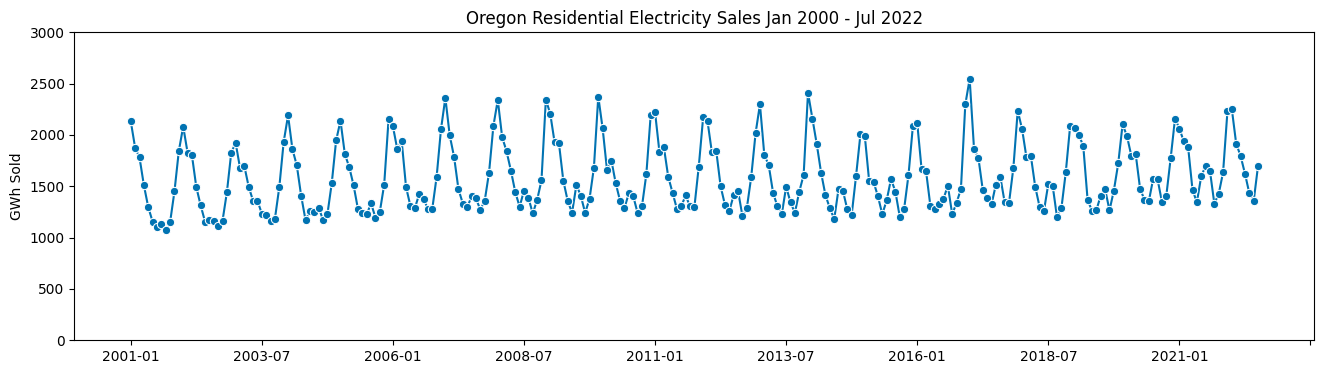

In [9]:
fig, ax = plot_series(df['sales'])
plt.title('Oregon Residential Electricity Sales Jan 2000 - Jul 2022')
plt.ylim(0, 3000)
plt.ylabel('GWh Sold');

### 3. Quick Models

#### a) Holt-Winters with Annual Periodicity

In [10]:
y = df['sales']
y_train, y_test = temporal_train_test_split(y, test_size=36)

In [11]:
y_train.index

PeriodIndex(['2001-01', '2001-02', '2001-03', '2001-04', '2001-05', '2001-06',
             '2001-07', '2001-08', '2001-09', '2001-10',
             ...
             '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03',
             '2019-04', '2019-05', '2019-06', '2019-07'],
            dtype='period[M]', length=223)

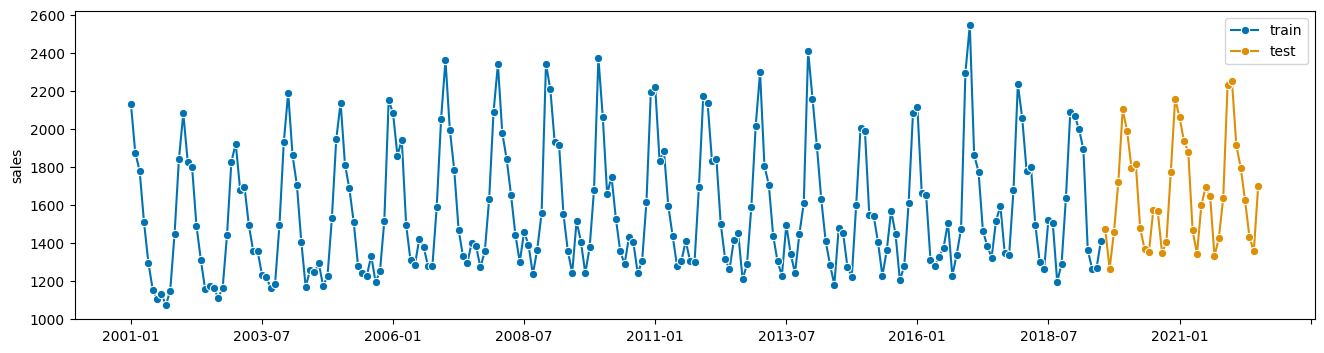

In [12]:
plot_series(y_train, y_test, labels=['train', 'test']);

**HW1: add/add**

In [13]:
hw1 = ExponentialSmoothing(
    y_train,
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()

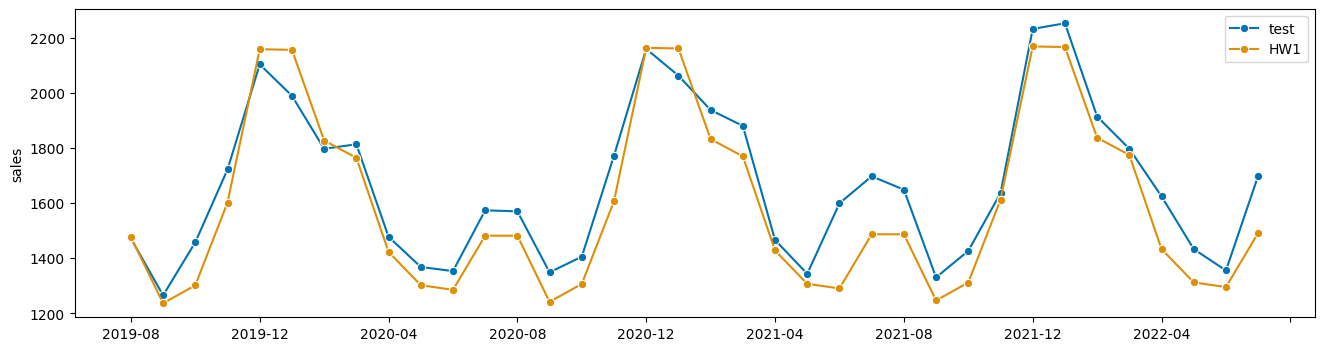

In [14]:
hwpreds1 = hw1.forecast(len(y_test))
plot_series(y_test, hwpreds1, labels=['test', 'HW1']);

In [15]:
mean_absolute_error(y_test, hwpreds1)

96.53419192628635

**HW2: add/mul**

In [16]:
hw2 = ExponentialSmoothing(
    y_train,
    trend='add',
    seasonal='mul',
    seasonal_periods=12
).fit()

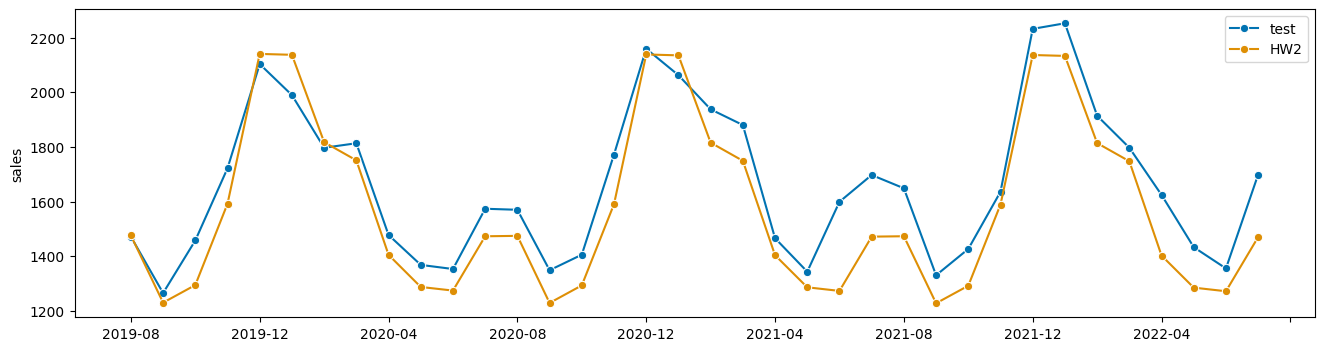

In [17]:
hwpreds2 = hw2.forecast(len(y_test))
plot_series(y_test, hwpreds2, labels=['test', 'HW2']);

In [18]:
mean_absolute_error(y_test, hwpreds2)

110.1207000616755

**HW3: mul/add**

In [19]:
hw3 = ExponentialSmoothing(
    y_train,
    trend='mul',
    seasonal='add',
    seasonal_periods=12
).fit()

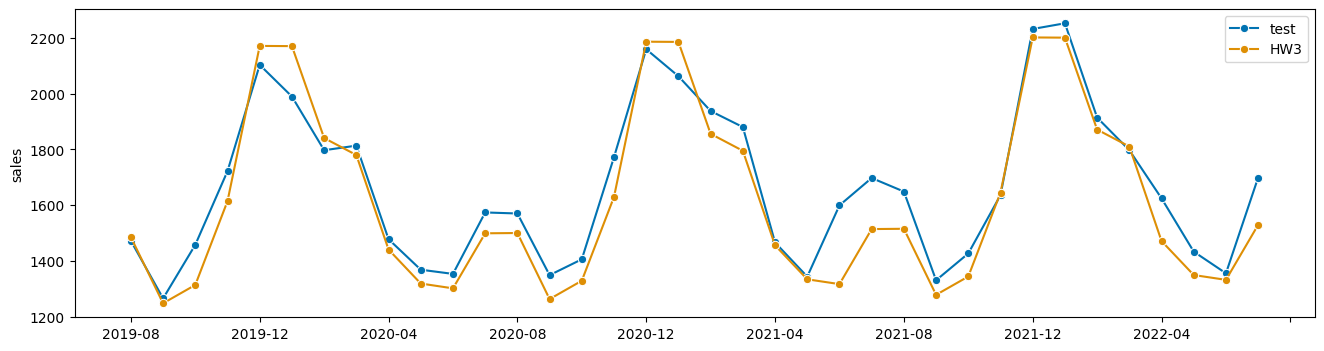

In [20]:
hwpreds3 = hw3.forecast(len(y_test))
plot_series(y_test, hwpreds3, labels=['test', 'HW3']);

In [21]:
mean_absolute_error(y_test, hwpreds3)

79.02964188367291

**HW4: mul/mul**

In [22]:
hw4 = ExponentialSmoothing(
    y_train,
    trend='mul',
    seasonal='mul',
    seasonal_periods=12
).fit()

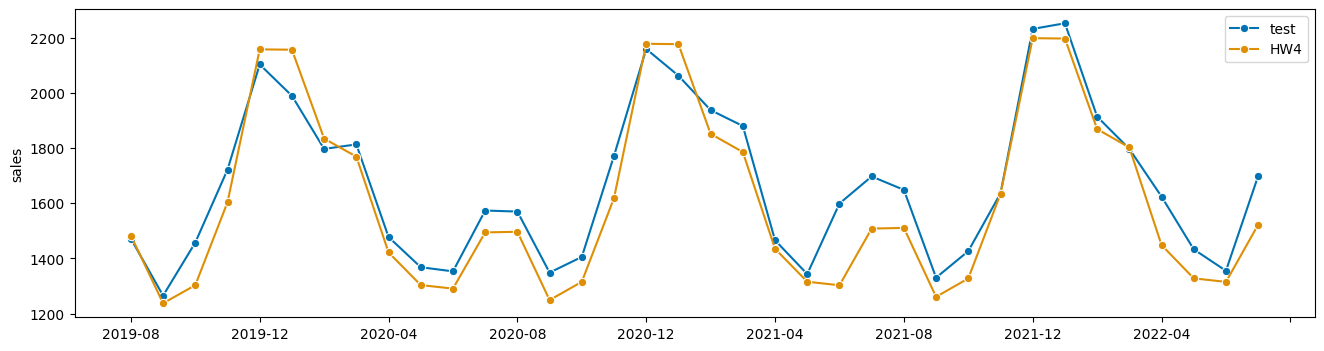

In [23]:
hwpreds4 = hw4.forecast(len(y_test))
plot_series(y_test, hwpreds4, labels=['test', 'HW4']);

In [24]:
mean_absolute_error(y_test, hwpreds4)

85.97261872877954

- The best Holt-Winters model uses a multiplicative trend and additive seasonality.
- This model achieves a MAE of about 79 GWh

**AutoETS:**

In [25]:
hw_auto = AutoETS(auto=True, sp=12,
                 trend='mul', seasonal='add')
hw_auto.fit(y_train)

AutoETS(auto=True, seasonal='add', sp=12, trend='mul')

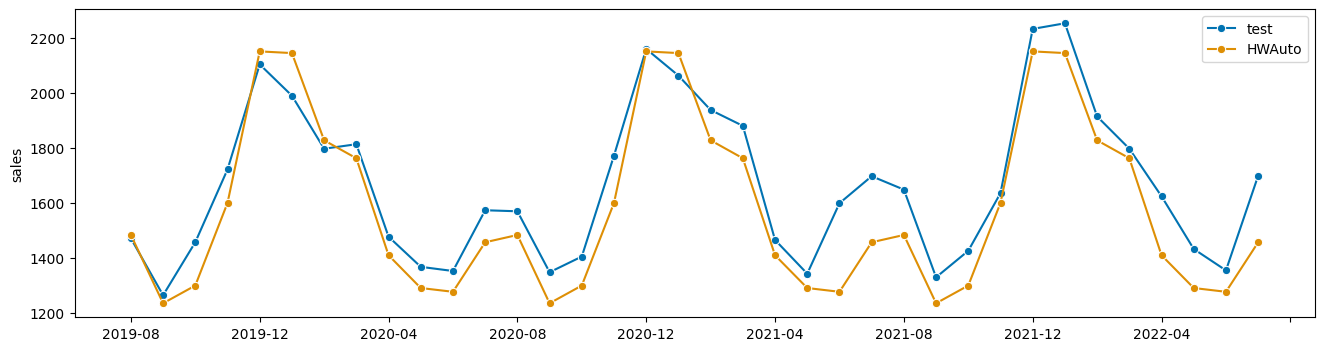

In [26]:
hwauto_preds = hw_auto.predict(y_test.index)
plot_series(y_test, hwauto_preds, labels=['test', 'HWAuto']);

In [27]:
mean_absolute_error(y_test, hwauto_preds)

105.78476575723076

#### b) SARIMA

**AutoARIMA:**

In [34]:
sarima_auto = AutoARIMA(sp=12, maxiter=200, trace=True)
sarima_auto.fit(y_train)

Performing stepwise search to minimize aic


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3225.870, Time=0.01 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2946.699, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3925.737, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=3064.438, Time=0.05 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=2711.144, Time=0.67 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=2762.807, Time=0.40 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=2711.496, Time=3.02 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=2895.438, Time=0.67 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=2738.098, Time=1.51 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=1.11 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=2739.405, Time=0.71 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=2719.283, Time=0.87 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,2)(1,0,1)[12] intercept   : AIC=2707.253, Time=0.98 sec
 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=2922.678, Time=0.34 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,2)(1,0,0)[12] intercept   : AIC=2761.543, Time=0.42 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,2)(2,0,1)[12] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(0,0,2)(1,0,2)[12] intercept   : AIC=inf, Time=1.37 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=3032.472, Time=0.11 sec
 ARIMA(0,0,2)(0,0,2)[12] intercept   : AIC=2879.068, Time=0.49 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,2)(2,0,0)[12] intercept   : AIC=2736.899, Time=1.46 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,2)(2,0,2)[12] intercept   : AIC=inf, Time=1.43 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.55 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,3)(1,0,1)[12] intercept   : AIC=2706.060, Time=1.15 sec
 ARIMA(0,0,3)(0,0,1)[12] intercept   : AIC=2917.774, Time=0.27 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,3)(1,0,0)[12] intercept   : AIC=2762.344, Time=0.49 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,3)(2,0,1)[12] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(0,0,3)(1,0,2)[12] intercept   : AIC=inf, Time=1.84 sec
 ARIMA(0,0,3)(0,0,0)[12] intercept   : AIC=3018.411, Time=0.08 sec
 ARIMA(0,0,3)(0,0,2)[12] intercept   : AIC=2878.395, Time=0.61 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,3)(2,0,0)[12] intercept   : AIC=2737.128, Time=1.60 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,3)(2,0,2)[12] intercept   : AIC=inf, Time=3.68 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(1,0,3)(1,0,1)[12] intercept   : AIC=inf, Time=2.19 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,4)(1,0,1)[12] intercept   : AIC=2912.810, Time=0.56 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(1,0,4)(1,0,1)[12] intercept   : AIC=inf, Time=1.91 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,3)(1,0,1)[12]             : AIC=inf, Time=0.60 sec

Best model:  ARIMA(0,0,3)(1,0,1)[12] intercept
Total fit time: 35.506 seconds


AutoARIMA(maxiter=200, sp=12, trace=True)

- Best AutoARIMA maxiter=50: (0,0,2)(1,0,0)[12]
- Best AutoARIMA maxiter=100: (0,0,3)(1,0,1)[12]
- Best AutoARIMA maxiter=200: (0,0,3)(1,0,1)[12]

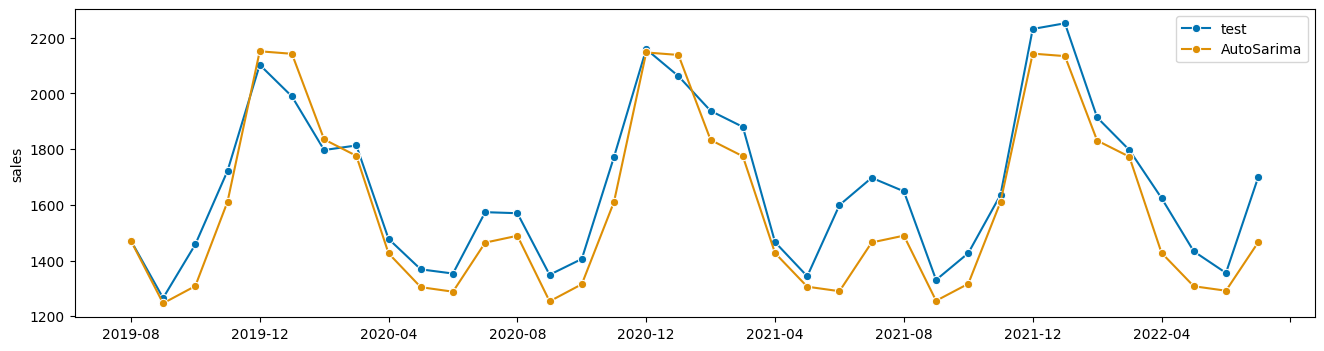

In [38]:
sarima_auto_preds = sarima_auto.predict(y_test.index)
plot_series(y_test, sarima_auto_preds, labels=['test', 'AutoSarima']);

In [36]:
mean_absolute_error(y_test, sarima_auto_preds)

97.09709462444107

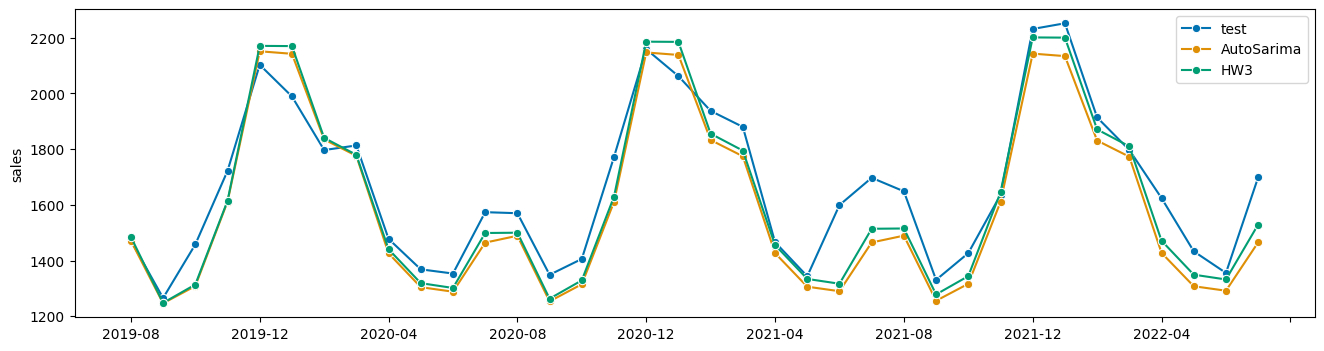

In [39]:
plot_series(y_test, sarima_auto_preds, hwpreds3, labels=['test', 'AutoSarima', 'HW3']);

#### c) Ensemble

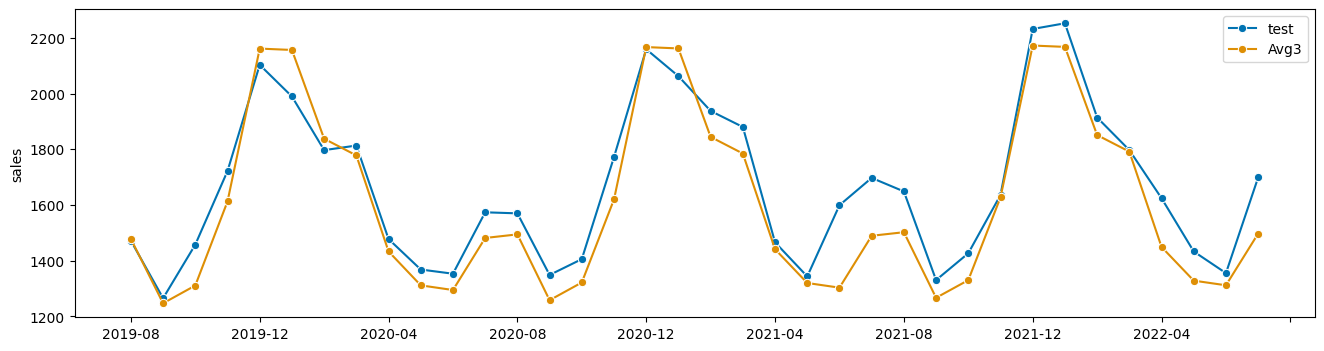

In [45]:
avg3_preds = (hwpreds3 + sarima_auto_preds) / 2
plot_series(y_test, avg3_preds, labels=['test', 'Avg3']);

In [46]:
mean_absolute_error(y_test, avg3_preds)

87.11559573633629

In [47]:
ens = EnsembleForecaster([
    ('AutoSarima', sarima_auto),
    ('AutoETS', hw_auto)
])

ens.fit(y_train)
ens_preds = ens.predict(y_test.index)

Performing stepwise search to minimize aic


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3225.870, Time=0.01 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2946.699, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3925.737, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=3064.438, Time=0.05 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=2711.144, Time=0.67 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=2762.807, Time=0.38 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=2711.496, Time=2.97 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=2895.438, Time=0.67 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=2738.098, Time=1.49 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=1.13 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=2739.405, Time=0.70 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=2719.283, Time=0.86 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,2)(1,0,1)[12] intercept   : AIC=2707.253, Time=0.96 sec
 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=2922.678, Time=0.33 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,2)(1,0,0)[12] intercept   : AIC=2761.543, Time=0.42 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,2)(2,0,1)[12] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(0,0,2)(1,0,2)[12] intercept   : AIC=inf, Time=1.31 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=3032.472, Time=0.11 sec
 ARIMA(0,0,2)(0,0,2)[12] intercept   : AIC=2879.068, Time=0.48 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,2)(2,0,0)[12] intercept   : AIC=2736.899, Time=1.43 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,2)(2,0,2)[12] intercept   : AIC=inf, Time=1.44 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.54 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,3)(1,0,1)[12] intercept   : AIC=2706.060, Time=1.12 sec
 ARIMA(0,0,3)(0,0,1)[12] intercept   : AIC=2917.774, Time=0.25 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,3)(1,0,0)[12] intercept   : AIC=2762.344, Time=0.48 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,3)(2,0,1)[12] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,0,3)(1,0,2)[12] intercept   : AIC=inf, Time=1.79 sec
 ARIMA(0,0,3)(0,0,0)[12] intercept   : AIC=3018.411, Time=0.08 sec
 ARIMA(0,0,3)(0,0,2)[12] intercept   : AIC=2878.395, Time=0.60 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,3)(2,0,0)[12] intercept   : AIC=2737.128, Time=1.60 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,3)(2,0,2)[12] intercept   : AIC=inf, Time=3.74 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(1,0,3)(1,0,1)[12] intercept   : AIC=inf, Time=2.12 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,4)(1,0,1)[12] intercept   : AIC=2912.810, Time=0.59 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(1,0,4)(1,0,1)[12] intercept   : AIC=inf, Time=1.92 sec


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,0,3)(1,0,1)[12]             : AIC=inf, Time=0.62 sec

Best model:  ARIMA(0,0,3)(1,0,1)[12] intercept
Total fit time: 35.125 seconds


- Best Arima (0,0,3)(1,0,1)[12]

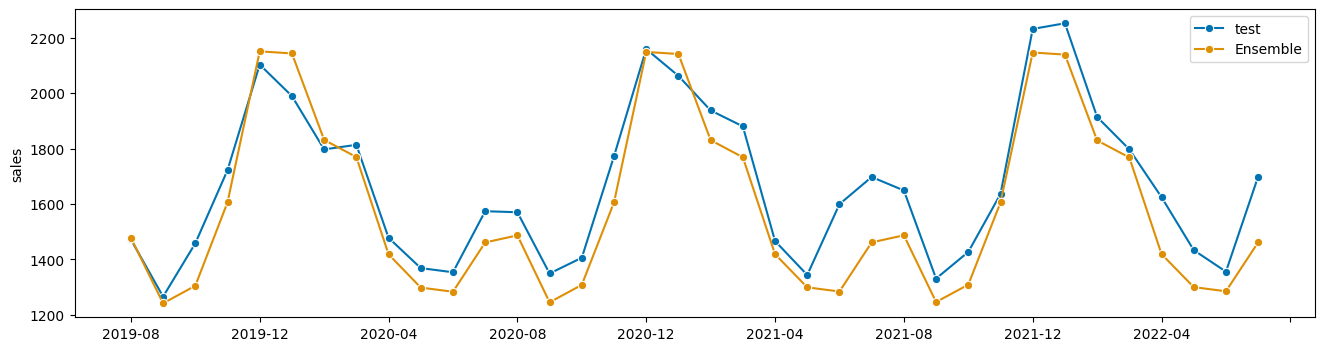

In [48]:
ens_preds = ens.predict(y_test.index)
plot_series(y_test, ens_preds, labels=['test', 'Ensemble']);

In [49]:
mean_absolute_error(y_test, ens_preds)

101.42817351189593

### 4. Save Data

In [52]:
df

,stateid,stateDescription,sectorid,sectorName,sales,sales-units
2001-01,OR,Oregon,RES,residential,2133.25752,million kilowatthours
2001-02,OR,Oregon,RES,residential,1874.70239,million kilowatthours
2001-03,OR,Oregon,RES,residential,1780.77004,million kilowatthours
2001-04,OR,Oregon,RES,residential,1510.45140,million kilowatthours
2001-05,OR,Oregon,RES,residential,1296.98239,million kilowatthours
...,...,...,...,...,...,...
2022-03,OR,Oregon,RES,residential,1796.99979,million kilowatthours
2022-04,OR,Oregon,RES,residential,1624.28015,million kilowatthours
2022-05,OR,Oregon,RES,residential,1433.05865,million kilowatthours
2022-06,OR,Oregon,RES,residential,1355.40892,million kilowatthours


In [54]:
df.drop(columns=['stateDescription', 'sectorName'], inplace=True)

In [55]:
df.to_csv('../../data/practice/OR_res_monthly.csv', index_label='month')